# Recommender Systems in Tensorflow 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

- Implementation of Matrix Factorization in Tensorflow 2.0 using feature columns
- Comparison to performance using fast.ai & bringing TensorFlow model to the same level (using cyclic learning rates (1-cycle policy))

Dataset: https://grouplens.org/datasets/movielens/1m/

In [0]:
# Use Tensorflow 2.0 
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  # Load the TensorBoard extension
  %load_ext tensorboard
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)

2.0.0


### Download Dataset

In [0]:
!wget https://storage.googleapis.com/dl-workshop/datasets/ml-1m/ratings.dat
!wget https://storage.googleapis.com/dl-workshop/datasets/ml-1m/movies.dat

!mkdir -vp data
!mv ratings.dat data/
!mv movies.dat data/
!ls data

--2019-11-21 17:06:28--  https://storage.googleapis.com/dl-workshop/datasets/ml-1m/ratings.dat
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24594131 (23M) [application/octet-stream]
Saving to: ‘ratings.dat’

ratings.dat         100%[===================>]  23.45M  17.1MB/s    in 1.4s    

2019-11-21 17:06:30 (17.1 MB/s) - ‘ratings.dat’ saved [24594131/24594131]

--2019-11-21 17:06:31--  https://storage.googleapis.com/dl-workshop/datasets/ml-1m/movies.dat
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171308 (167K) [application/octet-stream]
Saving to: ‘movies.dat’

movies.dat     

## Data Loading & Preprocessing


In [0]:
import pandas as pd
import os

dataset_path = 'data'

ratings_path ='data/ratings.dat'
movies_path = 'data/movies.dat'

ratings_columns = 'UserID::MovieID::Rating::Timestamp'.split('::')
movie_columns = 'MovieID::Title::Genres'.split('::')

df_ratings = pd.read_csv(ratings_path, sep='::', names=ratings_columns)
df_movies = pd.read_csv(os.path.join(dataset_path, 'movies.dat'), sep='::', names=movie_columns)
df_ratings = df_ratings.sample(frac=1, random_state=0)

df_ratings['UserID'] = df_ratings['UserID'] - 1
df_ratings['MovieID'] = df_ratings['MovieID'] - 1

df_ratings = df_ratings.join(df_movies.set_index('MovieID'), on='MovieID')

# | check number of unique users & movies
nr_users = len(df_ratings['UserID'].unique())
nr_movies = len(df_ratings['MovieID'].unique())
print('#Users: {}, #Movies: {}'.format(nr_users, nr_movies))

df_ratings.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


#Users: 6040, #Movies: 3706


,UserID,MovieID,Rating,Timestamp,Title,Genres
324271,1921,2093,4,974694867,Return to Oz (1985),Adventure|Children's|Fantasy|Sci-Fi
818637,4917,2807,1,963084545,Universal Soldier: The Return (1999),Action|Sci-Fi
148677,956,1659,4,975130093,Hurricane Streets (1998),Drama


In [0]:
train_ratings_path = os.path.join(dataset_path, 'ratings-train.dat')
val_ratings_path = os.path.join(dataset_path, 'ratings-val.dat')

train_size = int(0.8*len(df_ratings))
val_size = len(df_ratings) - train_size

df_ratings.iloc[:train_size].to_csv(train_ratings_path, sep=';', index=False, header=True)
df_ratings.iloc[train_size:].to_csv(val_ratings_path, sep=';', index=False, header=True)

# | for fast.ai
df_ratings['validation'] = False
df_ratings['validation'].iloc[train_size:] = True

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# TensorFlow

## Create data pipeline (tf.data.dataset)


In [0]:
def create_csv_dataset_hl(csv_path, label_name, select_columns=None, epochs=1, batch_size=8, buffer_size=10000, shuffle=False):
    return tf.data.experimental.make_csv_dataset(csv_path,
                                               batch_size=batch_size,
                                               field_delim=';',
                                               label_name=label_name,
                                               select_columns=select_columns,
                                               num_epochs=epochs,
                                               shuffle=shuffle,
                                               shuffle_buffer_size=buffer_size)

In [0]:
ds = create_csv_dataset_hl(train_ratings_path, 'Rating', epochs=-1, select_columns=[0,1,2], shuffle=False)

for data, label in ds.take(1):
    print(label)
    print(data)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
tf.Tensor([4 1 4 5 1 5 3 4], shape=(8,), dtype=int32)
OrderedDict([('UserID', <tf.Tensor: id=51, shape=(8,), dtype=int32, numpy=array([1921, 4917,  956, 4652, 3244, 5090,  703, 3939], dtype=int32)>), ('MovieID', <tf.Tensor: id=50, shape=(8,), dtype=int32, numpy=array([2093, 2807, 1659,  913, 3323,  587,  968, 3782], dtype=int32)>)])


### Define the feature columns

In [0]:
print(df_ratings['UserID'].max(), df_ratings['MovieID'].max())

6039 3951


In [0]:
feature_columns = []
embeddeding_size = 50

# user_id = tf.feature_column.categorical_column_with_hash_bucket('UserID', hash_bucket_size=1000, dtype=tf.dtypes.int32)
# movie_id = tf.feature_column.categorical_column_with_hash_bucket('MovieID', hash_bucket_size=1000, dtype=tf.dtypes.int32)
user_id = tf.feature_column.categorical_column_with_identity('UserID', num_buckets=6040)
movie_id = tf.feature_column.categorical_column_with_identity('MovieID', num_buckets=3952)

feature_columns.append(tf.feature_column.embedding_column(user_id, embeddeding_size))
feature_columns.append(tf.feature_column.embedding_column(movie_id, embeddeding_size))

bias_columns = []
bias_columns.append(tf.feature_column.embedding_column(user_id, 1))
bias_columns.append(tf.feature_column.embedding_column(movie_id, 1))

## Modelling

In [0]:
class RecommenderModel(tf.keras.Model):
  def __init__(self, feature_columns, bias_columns, use_bias=True, sigmoid_activation=True):
    super(RecommenderModel, self).__init__()
    self.feature_embedding_layer = tf.keras.layers.DenseFeatures(feature_columns)
    self.bias_embedding_layer = tf.keras.layers.DenseFeatures(bias_columns)
    self.use_bias = use_bias
    self.sigmoid_activation = sigmoid_activation

  @tf.function
  def call(self, x):
    feature_tensor = self.feature_embedding_layer(x)
    bias_tensor = self.bias_embedding_layer(x)
 
    # | Split into two equal parts, as hash_bucket_size of both feature_columns is equal
    user_id_tensor, movie_id_tensor = tf.split(feature_tensor, num_or_size_splits=2, axis=1)
    user_id_bias, movie_id_bias = tf.split(bias_tensor, num_or_size_splits=2, axis=1)
    
    # | Dot product of user vector with movie vector -> the more correlation between these vectors, the higher the ranking should be
    predicted_ranking = tf.reduce_sum(tf.multiply(user_id_tensor, movie_id_tensor), axis=1)

    # | Add biases
    if self.use_bias:
        predicted_ranking = tf.add(predicted_ranking, user_id_bias)
        predicted_ranking = tf.add(predicted_ranking, movie_id_bias)

    # | Add Sigmoid activation function (Ratings are between 1 and 5 --> design sigmoid accordingly)
    if self.sigmoid_activation:
        predicted_ranking = 5.5*tf.math.sigmoid(tf.add(1.6*predicted_ranking, -5))

    return predicted_ranking
   
   
def create_model(lr=3e-4, use_bias=False, sigmoid_activation=False):
    model = RecommenderModel(feature_columns=feature_columns, bias_columns=bias_columns, use_bias=use_bias, sigmoid_activation=sigmoid_activation)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])
    
    return model

## Training

In [0]:
batch_size = 64

train_dataset = create_csv_dataset_hl(train_ratings_path, 'Rating', batch_size = batch_size, epochs=-1, select_columns=[0,1,2], shuffle=True)
val_dataset = create_csv_dataset_hl(val_ratings_path, 'Rating', batch_size = batch_size, epochs=-1, select_columns=[0,1,2])

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [0]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

class MyCyclicLR(Callback):
    """
    Code from https://github.com/bckenstler/CLR.git
    Just needed to replace the imports at the beginning.. to make it compatible with TF 2.0
    """
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(MyCyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
def train(model, train_dataset, train_size, val_dataset=None, val_size=None, nr_epochs=10, batch_size=32, one_cycle=False, max_lr=5e-3):
    steps_per_epoch = train_size // batch_size
    validation_steps = val_size // batch_size
    callbacks = []

    from datetime import datetime
    ts = str(int(datetime.now().timestamp()))

    # | Tensorboard
    log_dir = './log/' + ts
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')
    callbacks.append(tb_callback)

    # | Checkpoints
    checkpoint_dir = './checkpoints/' + ts
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_dir + '/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                                        save_weights_only=True,
                                                        save_freq='epoch',
                                                        monitor='val_loss',
                                                        save_best_only=True)

    if one_cycle:
        # from clr_callback import CyclicLR
        max_lr = 5e-3
        step_size = (nr_epochs*steps_per_epoch)/2
        callbacks.append(MyCyclicLR(base_lr=max_lr/25, max_lr=max_lr, mode='triangular', step_size=step_size))

    else:
        # | Early Stopping
        earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto', restore_best_weights=True)
        callbacks.append(earlystop_callback)

        # | Learning Rate Reducer
        lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2, verbose=1)
        callbacks.append(lr_reducer)
        callbacks.append(checkpoint_callback)

    # | Training
    history = model.fit(train_dataset,
                        epochs=nr_epochs,
                        steps_per_epoch = steps_per_epoch,
                        validation_data=val_dataset, 
                        validation_steps=validation_steps,
                        callbacks=callbacks)
    
    return model, history

#### No Bias, No Sigmoid

In [0]:
model = create_model(lr=5e-3)
train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=10)

#### With Bias, No Sigmoid

In [0]:
model = create_model(lr=5e-3, use_bias=True, sigmoid_activation=False)
train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=100)

Train for 12502 steps, validate for 3125 steps
Epoch 1/100
12502/12502 [==============================] - 133s 11ms/step - loss: 2.0240 - mean_absolute_error: 1.0345 - mean_squared_error: 2.0240 - root_mean_squared_error: 1.4227 - val_loss: 0.9678 - val_mean_absolute_error: 0.7793 - val_mean_squared_error: 0.9678 - val_root_mean_squared_error: 0.9838
Epoch 2/100
12502/12502 [==============================] - 125s 10ms/step - loss: 0.9458 - mean_absolute_error: 0.7688 - mean_squared_error: 0.9458 - root_mean_squared_error: 0.9725 - val_loss: 0.9407 - val_mean_absolute_error: 0.7656 - val_mean_squared_error: 0.9407 - val_root_mean_squared_error: 0.9699
Epoch 3/100
12502/12502 [==============================] - 130s 10ms/step - loss: 0.9284 - mean_absolute_error: 0.7612 - mean_squared_error: 0.9284 - root_mean_squared_error: 0.9635 - val_loss: 0.9305 - val_mean_absolute_error: 0.7624 - val_mean_squared_error: 0.9305 - val_root_mean_squared_error: 0.9646
Epoch 4/100
12502/12502 [==========

#### With Bias, With Sigmoid

In [0]:
model = create_model(lr=5e-3, use_bias=True, sigmoid_activation=True)
train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=100)

Train for 12502 steps, validate for 3125 steps
Epoch 1/100
12502/12502 [==============================] - 41s 3ms/step - loss: 1.6283 - mean_absolute_error: 0.9688 - root_mean_squared_error: 1.2761 - val_loss: 1.1294 - val_mean_absolute_error: 0.8468 - val_root_mean_squared_error: 1.0627
Epoch 2/100
12502/12502 [==============================] - 40s 3ms/step - loss: 1.1201 - mean_absolute_error: 0.8472 - root_mean_squared_error: 1.0583 - val_loss: 1.1220 - val_mean_absolute_error: 0.8442 - val_root_mean_squared_error: 1.0593
Epoch 3/100
12502/12502 [==============================] - 40s 3ms/step - loss: 1.1121 - mean_absolute_error: 0.8443 - root_mean_squared_error: 1.0545 - val_loss: 1.1161 - val_mean_absolute_error: 0.8474 - val_root_mean_squared_error: 1.0564
Epoch 4/100
12502/12502 [==============================] - 41s 3ms/step - loss: 1.1080 - mean_absolute_error: 0.8430 - root_mean_squared_error: 1.0526 - val_loss: 1.1113 - val_mean_absolute_error: 0.8455 - val_root_mean_squared

In [0]:
model.save_weights('./final-model/checkpoint')

In [0]:
# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./final-model/checkpoint')

### With 1-cycle policy

... Now we finally get comparable results (mean squared error) to collab_learner() in fast.ai (see below)

In [0]:
model = create_model(lr=5e-3, use_bias=True, sigmoid_activation=False)
model, history = train(model, train_dataset, train_size, val_dataset, val_size, batch_size=batch_size, nr_epochs=5, one_cycle=True, max_lr=5e-3)

Train for 12502 steps, validate for 3125 steps
Epoch 1/5
12502/12502 [==============================] - 107s 9ms/step - loss: 6.7297 - mean_absolute_error: 2.0421 - mean_squared_error: 6.7297 - root_mean_squared_error: 2.5942 - val_loss: 1.2162 - val_mean_absolute_error: 0.8737 - val_mean_squared_error: 1.2162 - val_root_mean_squared_error: 1.1028
Epoch 2/5
12502/12502 [==============================] - 114s 9ms/step - loss: 0.9786 - mean_absolute_error: 0.7819 - mean_squared_error: 0.9786 - root_mean_squared_error: 0.9893 - val_loss: 0.9395 - val_mean_absolute_error: 0.7657 - val_mean_squared_error: 0.9395 - val_root_mean_squared_error: 0.9693
Epoch 3/5
12502/12502 [==============================] - 107s 9ms/step - loss: 0.9382 - mean_absolute_error: 0.7661 - mean_squared_error: 0.9382 - root_mean_squared_error: 0.9686 - val_loss: 0.9178 - val_mean_absolute_error: 0.7570 - val_mean_squared_error: 0.9178 - val_root_mean_squared_error: 0.9580
Epoch 4/5
12502/12502 [=====================

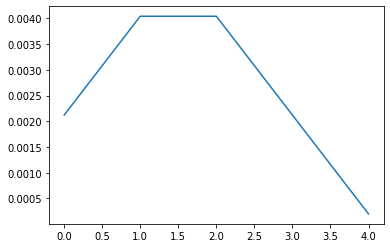

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['lr'])

## Analysis of predictions

In [0]:
movie_columns = 'MovieID::Title::Genres'.split('::')
movies_path = 'data/movies.dat'
df_movies = pd.read_csv(os.path.join(dataset_path, 'movies.dat'), sep='::', names=movie_columns)
df_movies['MovieID'] = df_movies['MovieID'] - 1
df_movies = df_movies.set_index('MovieID')
df_ratings_val = pd.read_csv(val_ratings_path, sep=';')

df_movies.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,Title,Genres
MovieID,,
0,Toy Story (1995),Animation|Children's|Comedy
1,Jumanji (1995),Adventure|Children's|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
3,Waiting to Exhale (1995),Comedy|Drama
4,Father of the Bride Part II (1995),Comedy


In [0]:
batch_size = 1
val_dataset = create_csv_dataset_hl(val_ratings_path, 'Rating', batch_size = 1, epochs=1, select_columns=[0,1,2])
predictions = model.predict(val_dataset, steps=len(df_ratings_val), verbose=1, workers=4)

200042/200042 [==============================] - 251s 1ms/step


In [0]:
import numpy as np

# | round predictions
y_pred = predictions.round().astype('int32')

# | ensure that results are in interval [1,5]
y_pred[np.where(y_pred < 1)] = 1
y_pred[np.where(y_pred > 5)] = 5

y_pred.min(), y_pred.max()

(1, 5)

In [0]:
from sklearn.metrics import mean_absolute_error

df_ratings_val = df_ratings_val.iloc[:len(y_pred)]
mean_absolute_error(df_ratings_val['Rating'], y_pred)

0.9603883184531249

In [0]:
df_comparison = pd.DataFrame({'pred': np.squeeze(y_pred), 'label': df_ratings_val['Rating'].values}, index = df_ratings_val['MovieID'])
df_comparison = df_comparison.sort_values(by='pred', axis=0, ascending=False)

df_comparison = pd.concat([df_movies.loc[df_comparison.index], df_comparison], axis=1)

df_comparison.head(100)

,Title,Genres,pred,label
MovieID,,,,
2897,"Dark Half, The (1993)",Horror|Mystery,5,3
918,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical,5,5
2079,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance,5,4
332,Tommy Boy (1995),Comedy,5,4
1911,Out of Sight (1998),Action|Crime|Romance,5,5
1072,Willy Wonka and the Chocolate Factory (1971),Adventure|Children's|Comedy|Fantasy,5,5
550,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical,5,5
1913,Smoke Signals (1998),Comedy|Drama,5,2
355,Forrest Gump (1994),Comedy|Romance|War,5,3


# Fast.AI approach


Does work much better than TF out of the box.

What configuration does fast.ai use?:

- doesn't use sigmoid by default.. (only when defining y_range argument in collab_learner, however this implementation actually seems to be wrong)
```python 
torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0] 
```
- uses one hot encoding (no hash_bucket) of users/movies
- uses bias (for both #user & #movie)
- in the fast.ai code there is a rule of thumb for calculating embedding sizes (however here we just use an embedding size of 50): 
```python 
def emb_sz_rule(n_cat:int)->int: return min(600, round(1.6 * n_cat**0.56))
# | n_cat is the number of categories, e.g. #Users, #Movies, ...
```

So far.. nothing really special.
However CollabLearner inherits from the Learner baseclass (whithout changing any of the default arguments), which has some interesting options activated:

- Weight Decay:
(defaults.wd = 1e-2, true_wd=True)
By default in Fastai library, the weight decay is 1e-2 It is less than it should because in rare cases too big weight decay is causing that model doesn’t learn and that might cause hard to recognize problem for beginners. Jeremy recommends using 1e-1 instead of the default because now when you understand that if parameters become zero then the weight decay is too high. Having too small weight decay is just going to overfit earlier so it doesn’t break the model right away.

The default weight decay will be wd, which will be handled using the method from [Fixing Weight Decay Regularization](https://arxiv.org/abs/1711.05101) in Adam if true_wd is set (otherwise it's L2 regularization). If true_wd is set it will affect all optimizers, not only Adam.

- Optimizer is AdamW (same as Adam but small changes for implementing (true) weight decay?)

**Results**:
- Using collab_learner(wd=0) without weight decay: Training is slower but end results are still significantly better than in TensorFlow... 

- When using embeddingsize=50 & no sigmoid activation in TF we get better results (than with bigger embedding size, such as 200), however, still not comparable to fast.ai

- When training fast.ai with learner.fit() instead of using 1-cycle policy, we finally get same results as in tensorflow --> so it's mainly a learning rate issue




In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
# data = CollabDataBunch.from_df(df_ratings, seed=42, valid_pct=0.2, item_name='Title')

In [0]:
batch_size = 64
embedding_size = 50
rating_name = 'Rating'
user_name = 'UserID'
item_name = 'MovieID'
cat_names = [user_name, item_name]

data = CollabList.from_df(df_ratings, cat_names=cat_names, procs=Categorify) \
                 .split_from_df(col='validation') \
                 .label_from_df(cols=rating_name) \
                 .databunch(bs=batch_size, val_bs=batch_size)

data.show_batch(3)

UserID,MovieID,target
2819,2656,4.0
2902,1643,4.0
4032,2114,4.0


In [0]:
# learn.lr_find(num_it=1000)
# learn.recorder.plot(skip_end=10)

### With bias, weight decay & sigmoid

In [0]:
learn = collab_learner(data, n_factors=embedding_size, y_range=[0, 5.5])
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.877579,0.853606,02:06
1,0.833464,0.859048,02:19
2,0.775253,0.815083,02:18
3,0.612501,0.782485,02:14
4,0.447126,0.787592,02:06


### With bias, weight decay

In [0]:
learn = collab_learner(data, n_factors=embedding_size)
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.135364,1.130077,02:03
1,1.079947,1.078794,02:15
2,0.861280,0.907813,02:15
3,0.707603,0.774266,02:09
4,0.601839,0.741988,02:03


### With bias

In [0]:
learn = collab_learner(data, n_factors=embedding_size, wd=0, true_wd=False)
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.080151,1.128480,01:59
1,1.016672,1.034428,02:12
2,0.832345,0.882976,02:13
3,0.643231,0.811179,02:08
4,0.512417,0.799990,02:00


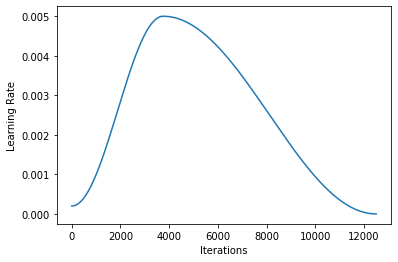

In [0]:
learn.recorder.plot_lr()

### With bias, No 1-cycle policy

This gives us comparable results to TensorFlow without cycling learning rates... so te reason for the performance boost in fast.ai seems to depend mainly on the training/learning rate schedule 

In [0]:
learn = collab_learner(data, n_factors=embedding_size, wd=0, true_wd=False)
learn.fit(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.975569,1.024511,02:00
1,0.937285,1.019601,02:05
2,0.895879,1.043847,02:06
3,0.853240,1.053256,02:05
4,0.845312,1.071324,02:05
